## Input Attention LSTM

This notebook shows how to generate interpretable results using deep learning model. The deep learning model used is Input Attention LSTM model of [Qin et al., 2017](https://arxiv.org/abs/1704.02971). The dataset used is of [Camels Australia](https://essd.copernicus.org/preprints/essd-2020-228/)

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/AtrCheema/ai4water_examples/blob/master/docs/source/_notebooks/model/interpretability_ia.ipynb)


[![View Source on GitHub](https://img.shields.io/badge/github-view%20source-black.svg)](https://github.com/AtrCheema/ai4water_examples/blob/master/docs/source/_notebooks/model/interpretability_ia.ipynb)

In [2]:
# try:
#     import ai4water
# except (ImportError, ModuleNotFoundError):
#     !pip install git+https://github.com/AtrCheema/AI4Water.git@b0cb440f1c5e28477e2d1ea6f3ece2f68851bd93

In [3]:
import tensorflow as tf
tf.compat.v1.disable_eager_execution()

D:\C\Anaconda3\envs\tfcpu27_py39\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
D:\C\Anaconda3\envs\tfcpu27_py39\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
D:\C\Anaconda3\envs\tfcpu27_py39\lib\site-packages\numpy\.libs\libopenblas.GK7GX5KEQ4F6UYO3P26ULGBQYHGQO7J4.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [4]:
import os

from easy_mpl import hist
import matplotlib.pyplot as plt

from ai4water import InputAttentionModel
from ai4water.datasets import CAMELS_AUS
from ai4water.postprocessing import Interpret
from ai4water.utils.utils import get_version_info

D:\C\Anaconda3\envs\tfcpu27_py39\lib\site-packages\sklearn\experimental\enable_hist_gradient_boosting.py:16: UserWarning: Since version 1.0, it is not needed to import enable_hist_gradient_boosting anymore. HistGradientBoostingClassifier and HistGradientBoostingRegressor are now stable and can be normally imported from sklearn.ensemble.
  warnings.warn(


In [5]:
for lib,ver in get_version_info().items():
    print(lib, ver)

python 3.9.7 | packaged by conda-forge | (default, Sep 29 2021, 19:20:16) [MSC v.1916 64 bit (AMD64)]
os nt
ai4water 1.06
lightgbm 3.3.1
tcn 3.4.0
catboost 0.26
xgboost 1.5.0
easy_mpl 0.21.3
SeqMetrics 1.3.3
tensorflow 2.7.0
keras.api._v2.keras 2.7.0
numpy 1.21.0
pandas 1.3.4
matplotlib 3.4.3
h5py 3.5.0
sklearn 1.0.1
shapefile 2.3.0
fiona 1.8.22
xarray 0.20.1
netCDF4 1.5.7
optuna 2.10.1
skopt 0.9.0
hyperopt 0.2.7
plotly 5.3.1
lime NotDefined
seaborn 0.11.2


In [6]:
dataset = CAMELS_AUS(
    path="F:\\data\\CAMELS\\CAMELS_AUS"  # path where data is downloaded. If data is not available, set path=None
)

inputs = ['et_morton_point_SILO',
           'precipitation_AWAP',
           'tmax_AWAP',
           'tmin_AWAP',
           'vprp_AWAP',
           'rh_tmax_SILO',
           'rh_tmin_SILO'
          ]

outputs = ['streamflow_MLd']


In [7]:

data = dataset.fetch('401203', dynamic_features=inputs+outputs, as_dataframe=True)
data

401203
time       dynamic_features                
1957-01-01 et_morton_point_SILO    8.062837
           precipitation_AWAP      0.000000
           tmax_AWAP              20.784480
           tmin_AWAP               4.358533
           vprp_AWAP               8.142806
...                                     ...
2014-12-31 tmin_AWAP               4.522077
           vprp_AWAP               8.885449
           rh_tmax_SILO           26.714771
           rh_tmin_SILO           75.013684
           streamflow_MLd        322.791000

[169472 rows x 1 columns]

In [8]:
data = data.unstack()
data.columns = [a[1] for a in data.columns.to_flat_index()]
data.head()

,et_morton_point_SILO,precipitation_AWAP,tmax_AWAP,tmin_AWAP,vprp_AWAP,rh_tmax_SILO,rh_tmin_SILO,streamflow_MLd
time,,,,,,,,
1957-01-01,8.062837,0.0,20.784480,4.358533,8.142806,28.888577,88.900993,538.551
1957-01-02,8.519483,0.0,27.393169,4.835900,5.281136,23.516738,99.002080,531.094
1957-01-03,9.879688,0.0,28.945301,8.175408,12.920509,19.434872,77.429917,503.011
1957-01-04,6.744638,0.0,26.133843,7.017990,13.951027,42.350667,100.000000,484.512
1957-01-05,8.135359,0.0,21.450775,8.686258,12.168659,30.374862,87.634483,463.416


In [9]:
data.shape

(21184, 8)

In [10]:
(data['streamflow_MLd'].values<0.0).sum()

0

In [11]:
(data['streamflow_MLd'].values==0.0).sum()

0

In [12]:
data.isna().sum()

et_morton_point_SILO    0
precipitation_AWAP      0
tmax_AWAP               0
tmin_AWAP               0
vprp_AWAP               0
rh_tmax_SILO            0
rh_tmin_SILO            0
streamflow_MLd          0
dtype: int64

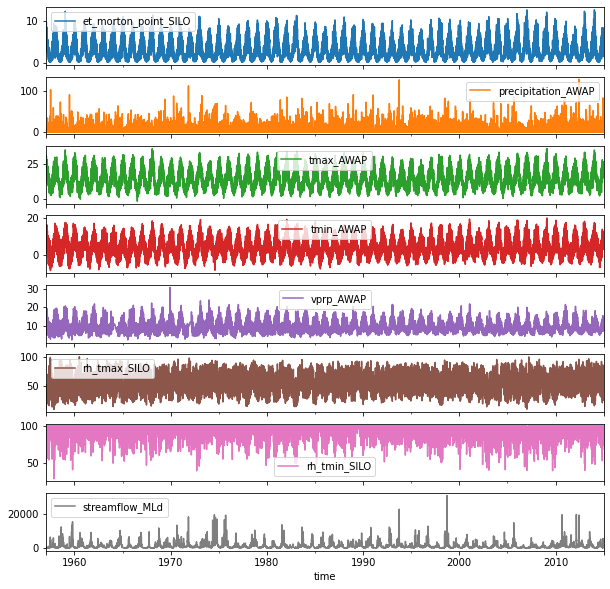

In [13]:
_ = data.plot(subplots=True, sharex=True, figsize=(10, 10))

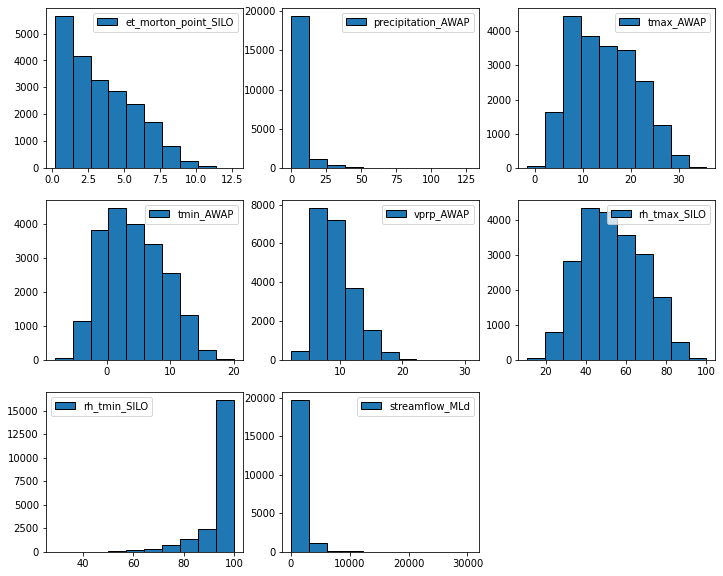

In [14]:


_ = hist(data, share_axes=False, subplots_kws=dict(figsize=(12, 10)), edgecolor = "k", grid=False)

In [15]:
skew_inputs = [
               'precipitation_AWAP',
           'rh_tmin_SILO'
]

In [16]:
normal_inputs = ['et_morton_point_SILO',
           'tmax_AWAP',
           'tmin_AWAP',
           'vprp_AWAP',
           'rh_tmax_SILO',
          ]

In [17]:


model = InputAttentionModel(
                input_features=inputs,
                output_features=outputs, 
                epochs=500,  
                ts_args={'lookback':15},
                lr=0.0001,
                batch_size=64,
                x_transformation=[{'method': 'robust', 'features': normal_inputs},
                                {'method': 'log', "replace_zeros": True, 'features': skew_inputs}],
                y_transformation={'method': 'robust', 'features': outputs},
    verbosity=0
)

building input attention model


In [18]:
model.verbosity=1

In [19]:
model.inputs

[<tf.Tensor 'enc_input1:0' shape=(None, 15, 7) dtype=float32>,
 <tf.Tensor 'enc_first_cell_state_1:0' shape=(None, 20) dtype=float32>,
 <tf.Tensor 'enc_first_hidden_state_1:0' shape=(None, 20) dtype=float32>]

In [20]:
model.outputs

[<tf.Tensor 'dense/BiasAdd:0' shape=(None, 1) dtype=float32>]

input_x shape:  [(11854, 15, 7), (11854, 20), (11854, 20)]
target shape:  (11854, 1)


inferred mode is regression. Ignore this message if the inferred mode is correct.


input_x shape:  [(2964, 15, 7), (2964, 20), (2964, 20)]
target shape:  (2964, 1)
Train on 11854 samples, validate on 2964 samples
Epoch 1/500
11584/11854 [============================>.] - ETA: 0s - loss: 1.4162

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.


11854/11854 [==============================] - 8s 714us/sample - loss: 1.4206 - val_loss: 1.3942
Epoch 2/500
11854/11854 [==============================] - 2s 139us/sample - loss: 1.2633 - val_loss: 1.2610
Epoch 3/500
11854/11854 [==============================] - 2s 135us/sample - loss: 1.1647 - val_loss: 1.1965
Epoch 4/500
11854/11854 [==============================] - 2s 137us/sample - loss: 1.0976 - val_loss: 1.1317
Epoch 5/500
11854/11854 [==============================] - 2s 137us/sample - loss: 1.0283 - val_loss: 1.0351
Epoch 6/500
11854/11854 [==============================] - 2s 137us/sample - loss: 0.9542 - val_loss: 0.9281
Epoch 7/500
11854/11854 [==============================] - 2s 137us/sample - loss: 0.8775 - val_loss: 0.8254
Epoch 8/500
11854/11854 [==============================] - 2s 135us/sample - loss: 0.8192 - val_loss: 0.8105
Epoch 9/500
11854/11854 [==============================] - 2s 135us/sample - loss: 0.7794 - val_loss: 0.7468
Epoch 10/500
11854/11854 [=====

11854/11854 [==============================] - 2s 139us/sample - loss: 0.2633 - val_loss: 0.4619
Epoch 150/500
11854/11854 [==============================] - 2s 134us/sample - loss: 0.2658 - val_loss: 0.4548
Epoch 151/500
11854/11854 [==============================] - 2s 139us/sample - loss: 0.2567 - val_loss: 0.4708
Epoch 152/500
11854/11854 [==============================] - 2s 139us/sample - loss: 0.2578 - val_loss: 0.4828
Epoch 153/500
11854/11854 [==============================] - 2s 132us/sample - loss: 0.2558 - val_loss: 0.4885
Epoch 154/500
11854/11854 [==============================] - 2s 132us/sample - loss: 0.2535 - val_loss: 0.4606
Epoch 155/500
11854/11854 [==============================] - 2s 130us/sample - loss: 0.2567 - val_loss: 0.4817
Epoch 156/500
11854/11854 [==============================] - 2s 132us/sample - loss: 0.2528 - val_loss: 0.4849
Epoch 157/500
11854/11854 [==============================] - 2s 132us/sample - loss: 0.2534 - val_loss: 0.5077
Epoch 158/500
1

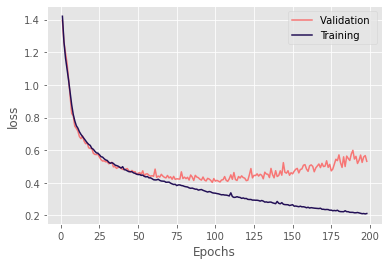

********** Successfully loaded weights from weights_098_0.40258.hdf5 file **********


In [21]:
h = model.fit(data=data)

Making predictions on training data

input_x shape:  [(11854, 15, 7), (11854, 20), (11854, 20)]
target shape:  (11854, 1)


`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.


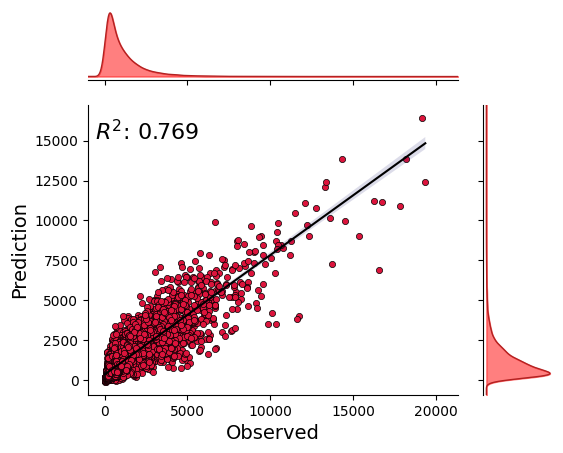

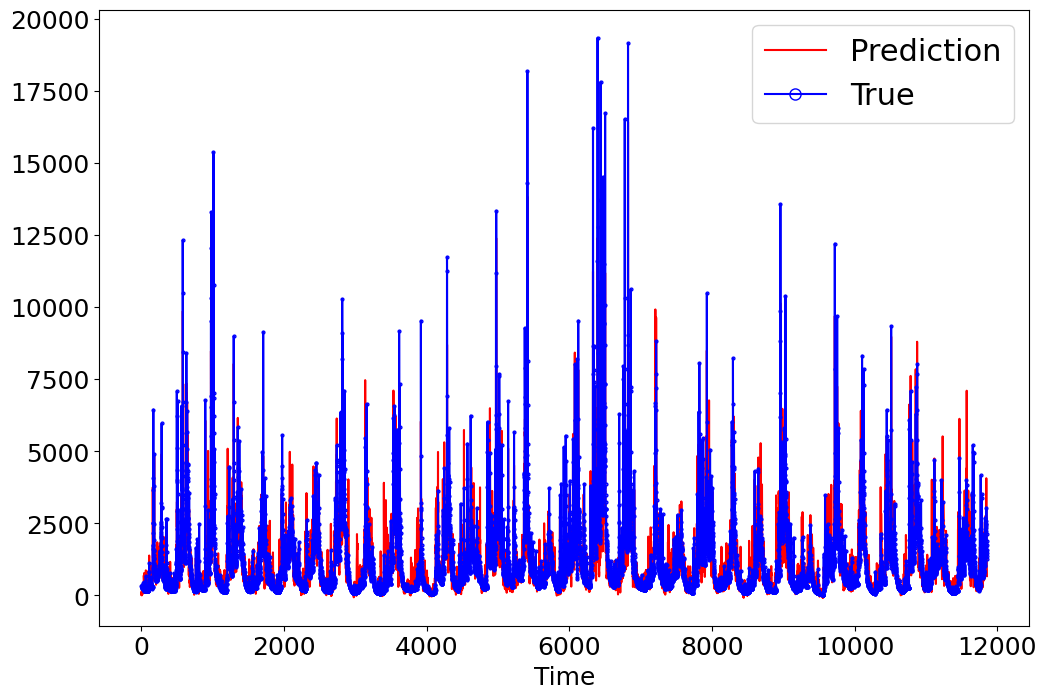

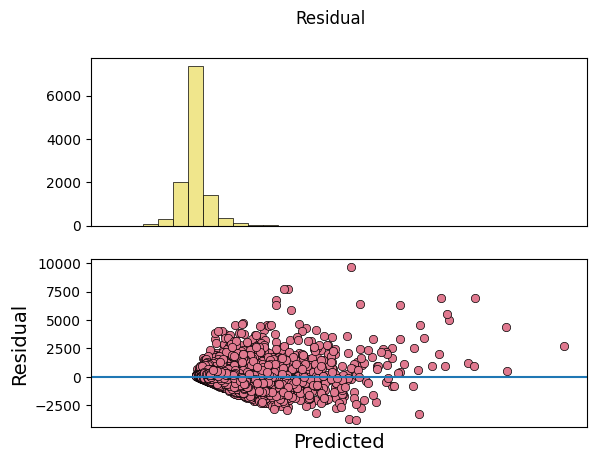

invalid value encountered in log2
invalid value encountered in log1p
invalid value encountered in log1p
invalid value encountered in log1p
invalid value encountered in log1p


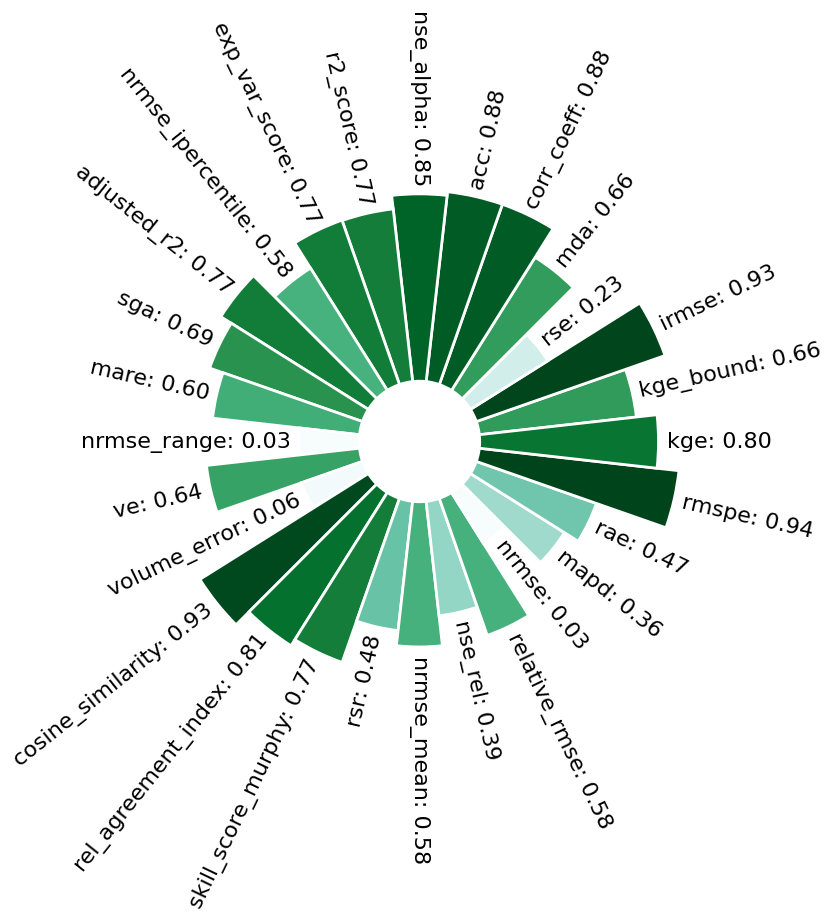

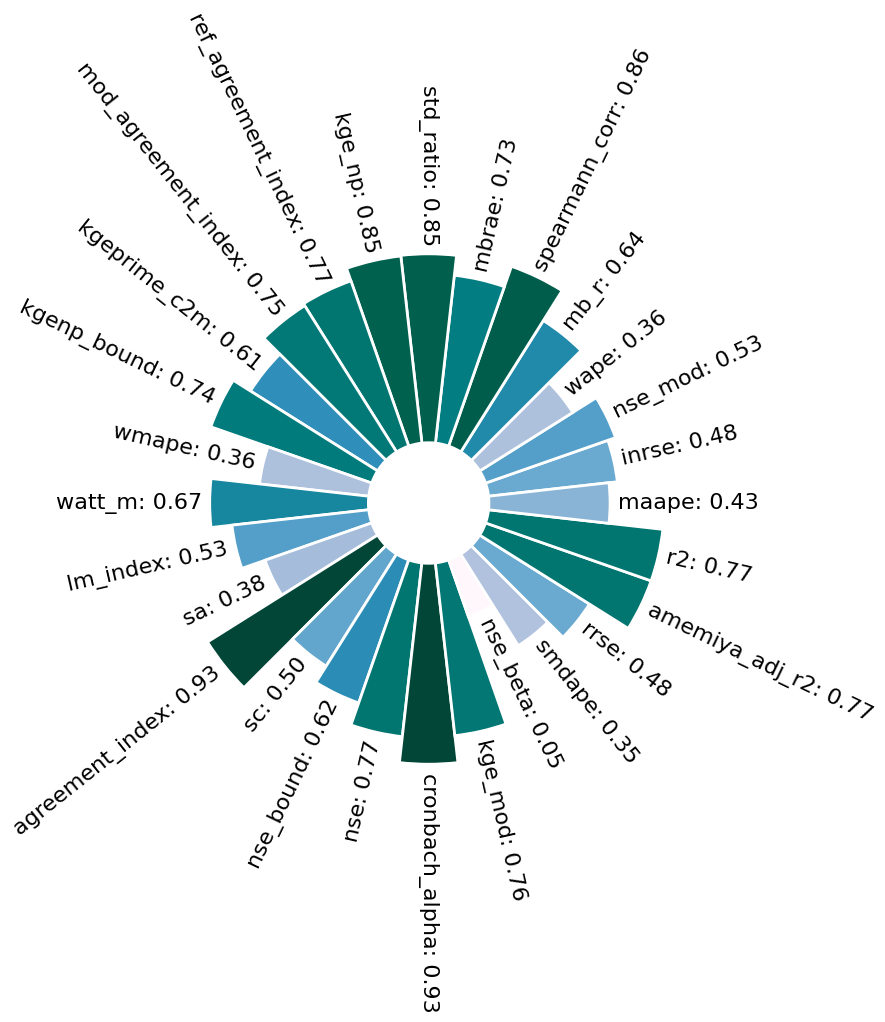

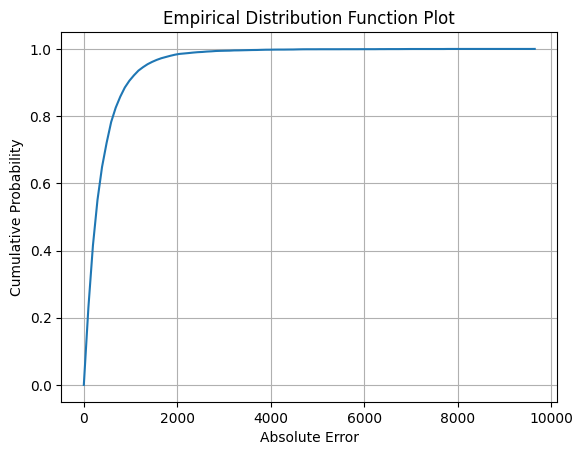

In [22]:
_ = model.predict_on_training_data(data=data)

Making predictions on test data

input_x shape:  [(6352, 15, 7), (6352, 20), (6352, 20)]
target shape:  (6352, 1)


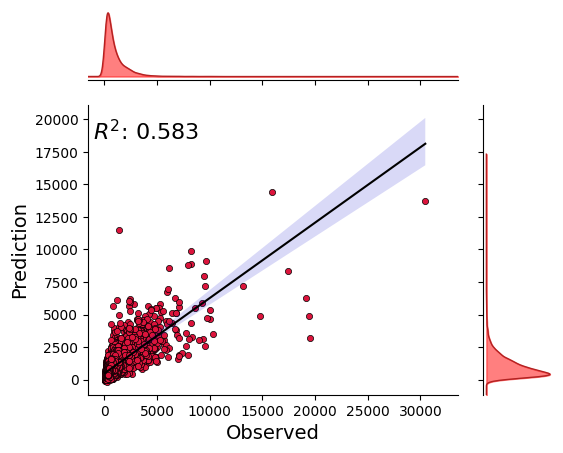

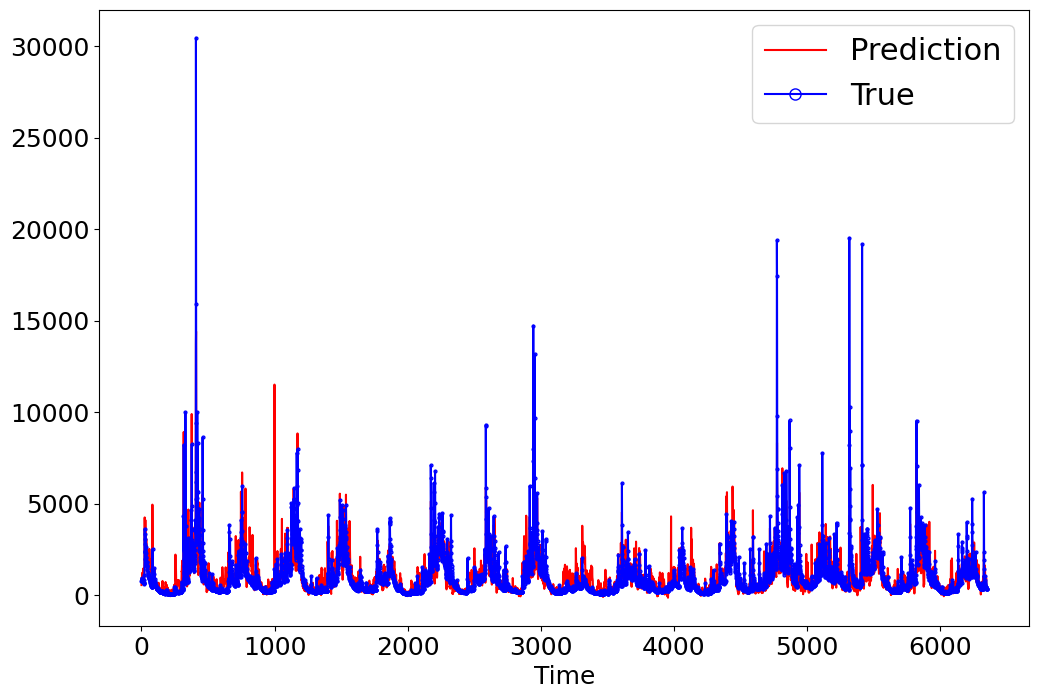

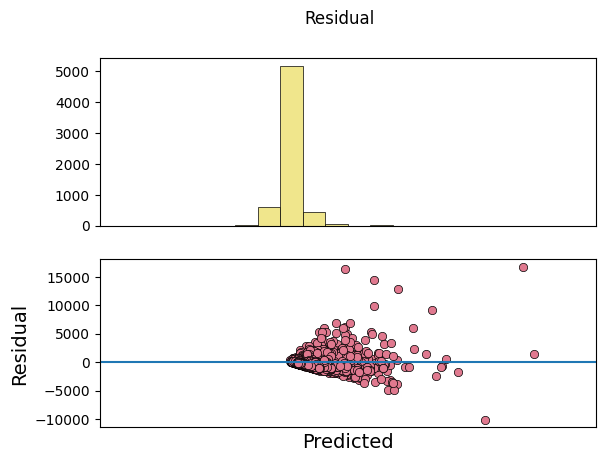

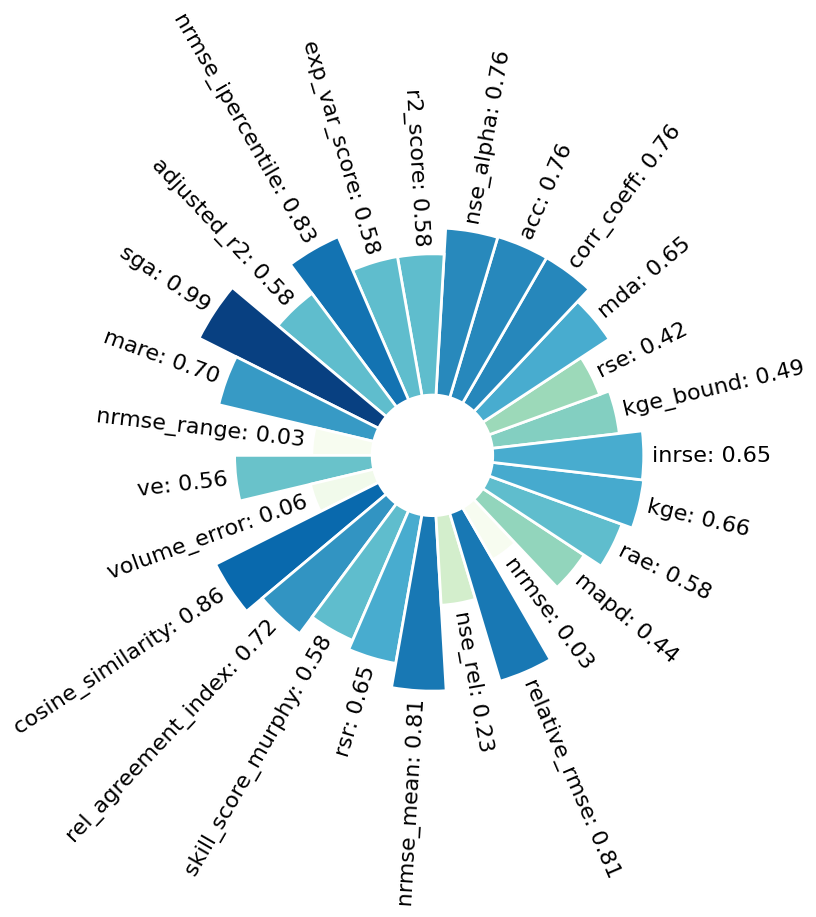

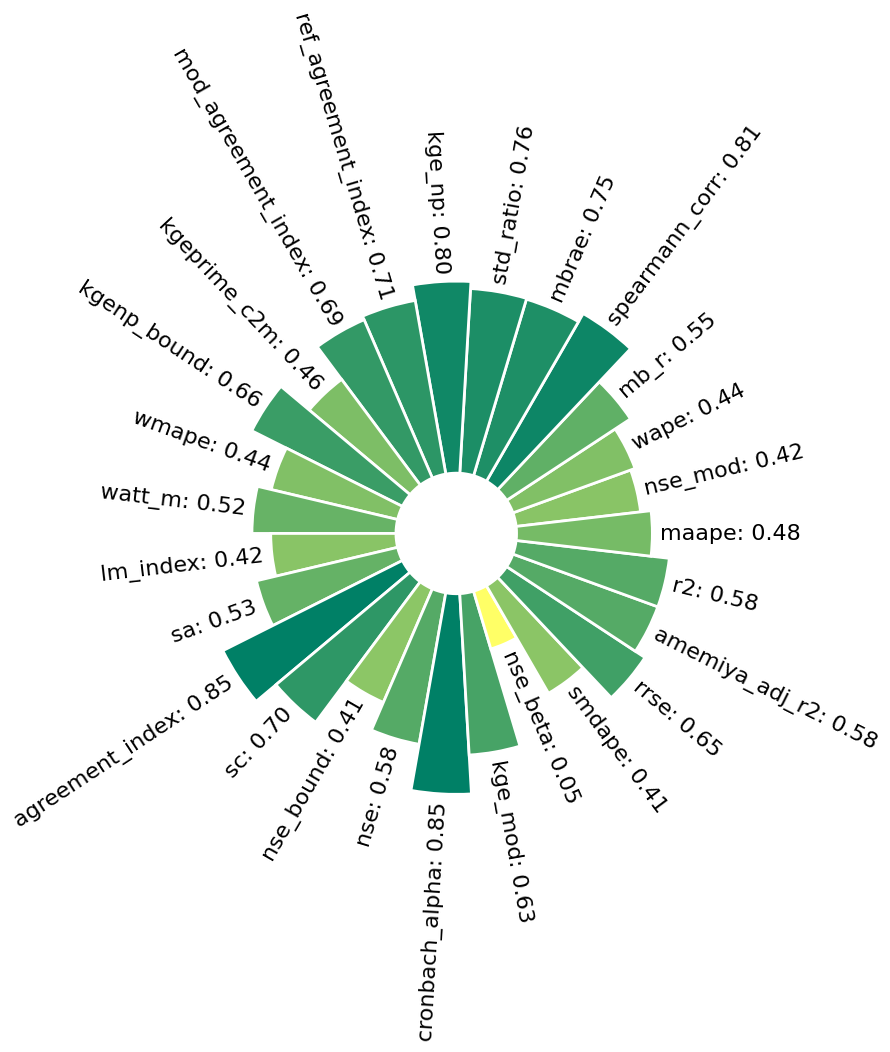

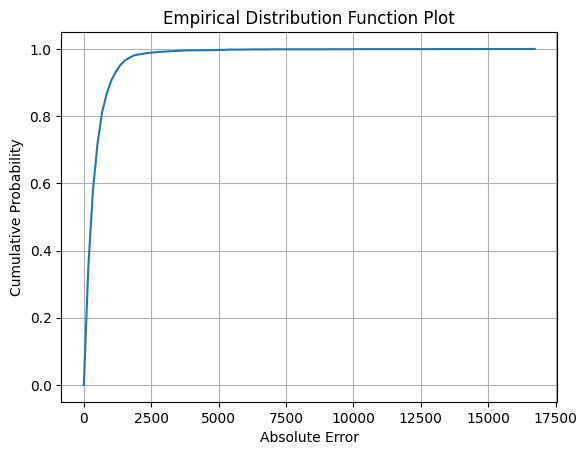

In [23]:
_ = model.predict_on_test_data(data=data)

Getting interpretable results

input_x shape:  [(11854, 15, 7), (11854, 20), (11854, 20)]
target shape:  (11854, 1)


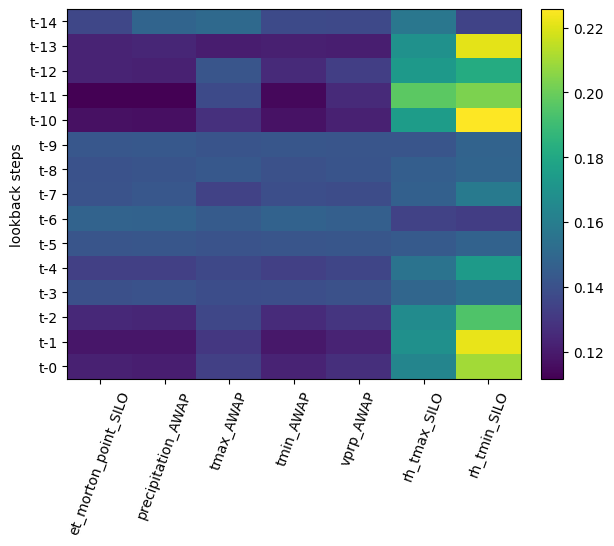

In [24]:
_ = model.plot_avg_attentions_along_inputs(data=data, 
                                          colorbar=True)

input_x shape:  [(11854, 15, 7), (11854, 20), (11854, 20)]
target shape:  (11854, 1)
input_x shape:  [(11854, 15, 7), (11854, 20), (11854, 20)]
target shape:  (11854, 1)



            argument test is deprecated and will be removed in future. Please 
            use 'predict_on_test_data' method instead.


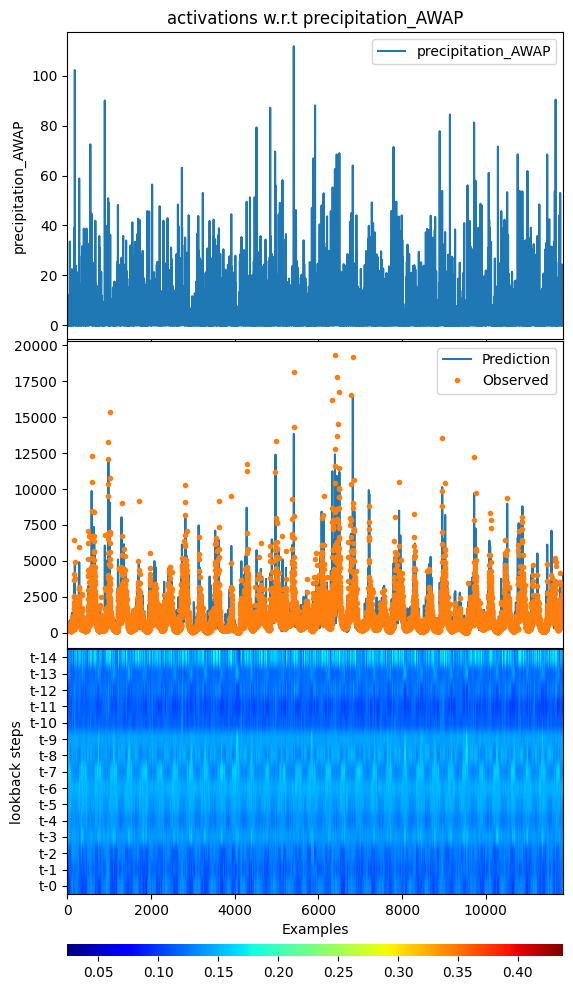

In [29]:
_ = model.plot_act_along_inputs(data=data, feature="precipitation_AWAP",
                               cbar_params={"pad": 0.5}, cmap="jet")

input_x shape:  [(11854, 15, 7), (11854, 20), (11854, 20)]
target shape:  (11854, 1)
input_x shape:  [(11854, 15, 7), (11854, 20), (11854, 20)]
target shape:  (11854, 1)



            argument test is deprecated and will be removed in future. Please 
            use 'predict_on_test_data' method instead.


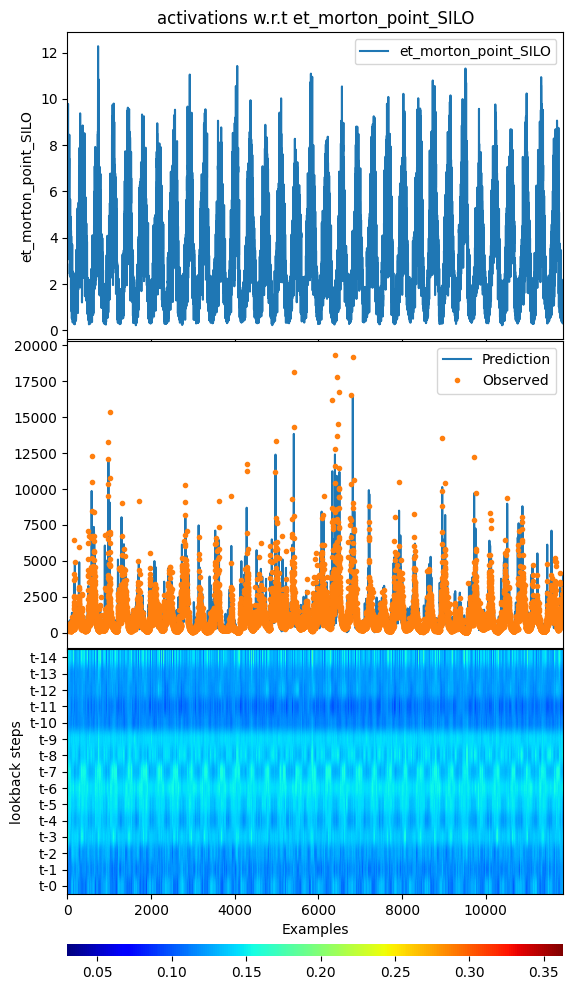

In [26]:
_ = model.plot_act_along_inputs(data=data, feature="et_morton_point_SILO",
                               cbar_params={"pad": 0.5}, cmap="jet")

input_x shape:  [(11854, 15, 7), (11854, 20), (11854, 20)]
target shape:  (11854, 1)
input_x shape:  [(11854, 15, 7), (11854, 20), (11854, 20)]
target shape:  (11854, 1)



            argument test is deprecated and will be removed in future. Please 
            use 'predict_on_test_data' method instead.


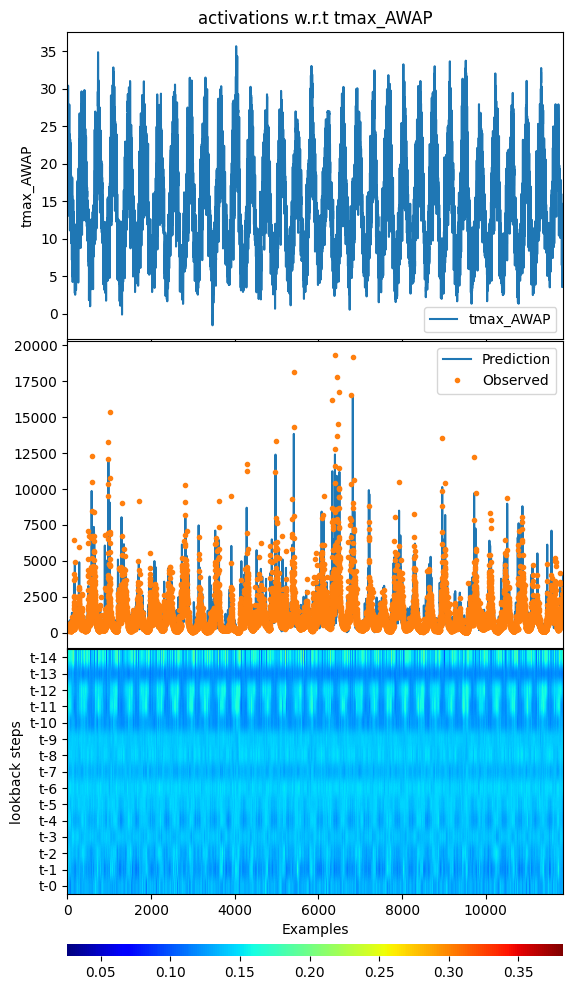

In [30]:
_ = model.plot_act_along_inputs(data=data, feature="tmax_AWAP",
                               cbar_params={"pad": 0.5}, cmap="jet")

In [28]:
print(f'All results are saved in {model.path}')

All results are saved in D:\mytools\ai4water_examples\docs\source\_notebooks\results\20230212_205108
